# Mean Modeling

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 

In [29]:
# import data
df = pd.read_csv('../data/processed/SPY_Close_modeling_2.5y.csv')
df.head()

,Date,close,log_return
0,2023-01-04,3852.97,0.007511
1,2023-01-05,3808.10,-0.011714
2,2023-01-06,3895.08,0.022584
3,2023-01-09,3892.09,-0.000768
4,2023-01-10,3919.25,0.006954


### Stationary Test

In [30]:
y = df["log_return"].dropna()

adf_stat, pvalue, usedlag, nobs, crit, icbest = adfuller(y, autolag="AIC")
print("ADF statistic:", adf_stat)
print("p-value:", pvalue)
print("critical values:", crit)

if pvalue < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF statistic: -14.116314964851812
p-value: 2.4690496925913105e-26
critical values: {'1%': np.float64(-3.440975679277454), '5%': np.float64(-2.8662281164567927), '10%': np.float64(-2.5692666752547626)}
The series is stationary.


The ADF test statistic is -14.11 with a p-value close to zero.
We reject the null hypothesis of unit root.
Therefore, the log return series is stationary.

### ACF Test 

<Figure size 640x480 with 0 Axes>

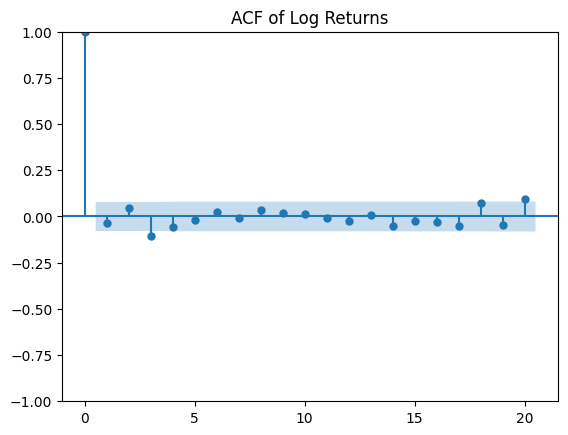

<Figure size 640x480 with 0 Axes>

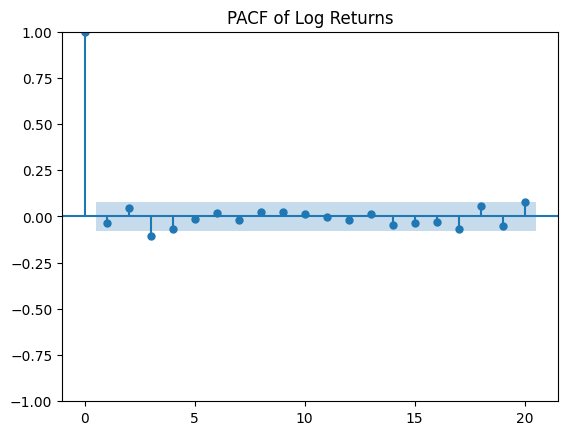

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure()
plot_acf(y, lags=20)
plt.title("ACF of Log Returns")
plt.show()

plt.figure()
plot_pacf(y, lags=20, method='ywm')
plt.title("PACF of Log Returns")
plt.show()

### Modeling

In [32]:
from statsmodels.tsa.arima.model import ARIMA

y = df["log_return"].dropna()

## Model Selection
max_p = 9
max_d =0  
max_q = 9

results = []

for p in range(0, 10):
    for q in range(0, 10):
        try:
            model = ARIMA(y, order=(p,0,q))
            fit = model.fit()

            results.append({
                "p": p,
                "d": 0,
                "q": q,
                "AIC": fit.aic,
                "BIC": fit.bic
            })
        except:
            continue

results_df = pd.DataFrame(results)

# Sort by BIC (lower is better)
results_df = results_df.sort_values("BIC").reset_index(drop=True)

print("Best models by BIC:")
print(results_df.head(10))

/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

Best models by BIC:
   p  d  q          AIC          BIC
0  0  0  0 -3968.626939 -3959.761059
1  1  0  0 -3967.295425 -3953.996605
2  0  0  1 -3967.186934 -3953.888114
3  0  0  3 -3971.564811 -3949.400111
4  3  0  0 -3971.307128 -3949.142428
5  2  0  0 -3966.515810 -3948.784050
6  0  0  2 -3966.311538 -3948.579777
7  1  0  1 -3964.627458 -3946.895698
8  4  0  0 -3972.204848 -3945.607208
9  0  0  4 -3972.026112 -3945.428472


In [33]:
# Identify the best model based on BIC
best = results_df.iloc[0]
best_order = (int(best["p"]), int(best["d"]), int(best["q"]))
print("\nBest ARIMA order by BIC:", best_order)


Best ARIMA order by BIC: (0, 0, 0)


In [39]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                  622
Model:                          ARIMA   Log Likelihood                1986.313
Date:                Fri, 13 Feb 2026   AIC                          -3968.627
Time:                        17:00:41   BIC                          -3959.761
Sample:                             0   HQIC                         -3965.181
                                - 622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.914      0.056   -1.83e-05       0.002
sigma2      9.847e-05   1.99e-06     49.482      0.000    9.46e-05       0.000
Ljung-Box (L1) (Q):                   0.67   Jarque-

We choose AR(9) as our mean model

In [35]:
# Ljung-Box test for residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
best_model = ARIMA(y, order=best_order).fit()
residuals = best_model.resid
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box test results:")
print(ljung_box_results)


Ljung-Box test results:
     lb_stat  lb_pvalue
10  12.93963   0.227067


H0: the residuals are white noice
p-value = 0.999966 > 0.05, cannot reject H0

There is no autocorrelation in residuals, which means mean model is a good fit. 

In [37]:
from statsmodels.stats.diagnostic import het_arch

residuals = best_model.resid

arch_test = het_arch(residuals, nlags=10)

lm_stat = arch_test[0]
lm_pvalue = arch_test[1]
f_stat = arch_test[2]
f_pvalue = arch_test[3]

print("ARCH LM Test Results")
print("LM Statistic:", lm_stat)
print("LM p-value:", lm_pvalue)
print("F Statistic:", f_stat)
print("F p-value:", f_pvalue)

ARCH LM Test Results
LM Statistic: 124.57883266754504
LM p-value: 5.940558892569671e-22
F Statistic: 15.360818005289204
F p-value: 1.2578080929656606e-24


The ARCH LM test strongly rejects the null hypothesis of no ARCH effects (LM p-value ≈ 0). This indicates the presence of significant conditional heteroskedasticity in the residuals. Therefore, the mean model alone is insufficient, and a GARCH-type model is required to properly capture volatility clustering.

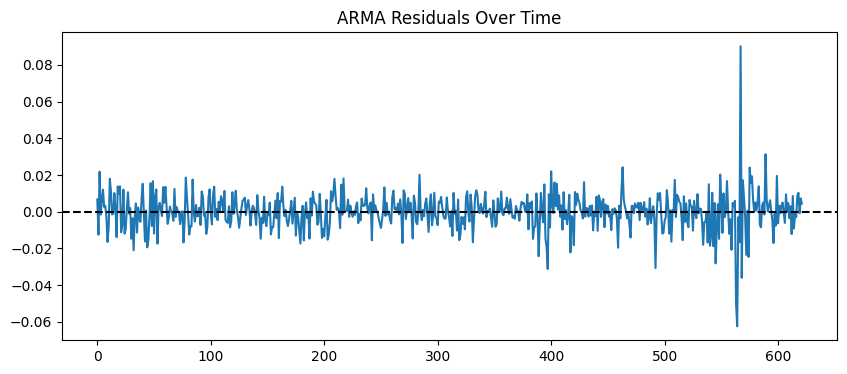

In [38]:
# Plot residuals to show volatility clustering

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("ARMA Residuals Over Time")
plt.axhline(0, color="black", linestyle="--")
plt.show()

The residuals fluctuate around zero, indicating that the mean dynamics have been adequately captured. However, clear volatility clustering is observed, particularly during crisis periods (e.g., 2020), suggesting time-varying conditional variance.